# MODEL BUILDING

Import Necessary Libraries


In [3]:
import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

#  Load Preprocessed Data 

In [4]:
X_train = np.load('preprocessed_data\X_train.npy')
y_train = np.load('preprocessed_data\y_train.npy')
X_test = np.load('preprocessed_data\X_test.npy')
y_test = np.load('preprocessed_data\y_test.npy')
# Assuming X_train, y_train, X_test, y_test are already available
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

<>:1: SyntaxWarning: invalid escape sequence '\X'
<>:2: SyntaxWarning: invalid escape sequence '\y'
<>:3: SyntaxWarning: invalid escape sequence '\X'
<>:4: SyntaxWarning: invalid escape sequence '\y'
<>:1: SyntaxWarning: invalid escape sequence '\X'
<>:2: SyntaxWarning: invalid escape sequence '\y'
<>:3: SyntaxWarning: invalid escape sequence '\X'
<>:4: SyntaxWarning: invalid escape sequence '\y'
C:\Users\revan\AppData\Local\Temp\ipykernel_21080\1154492365.py:1: SyntaxWarning: invalid escape sequence '\X'
  X_train = np.load('preprocessed_data\X_train.npy')
C:\Users\revan\AppData\Local\Temp\ipykernel_21080\1154492365.py:2: SyntaxWarning: invalid escape sequence '\y'
  y_train = np.load('preprocessed_data\y_train.npy')
C:\Users\revan\AppData\Local\Temp\ipykernel_21080\1154492365.py:3: SyntaxWarning: invalid escape sequence '\X'
  X_test = np.load('preprocessed_data\X_test.npy')
C:\Users\revan\AppData\Local\Temp\ipykernel_21080\1154492365.py:4: SyntaxWarning: invalid escape sequence '\y'

Shape of X_train: (4491, 256, 256, 1)
Shape of y_train: (4491,)


#  Define the Model Architecture Using Pre-trained ResNet50

In [7]:
IMG_SIZE = 256  # Assuming images were resized to 256x256 in preprocessing

# Define the input shape (grayscale images have 1 channel)
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Load the ResNet50 model with ImageNet weights, excluding the top fully-connected layers
# ResNet50 expects 3-channel images, so we need to adjust the input accordingly
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Define the custom input layer for grayscale images
inputs = Input(shape=input_shape)

# Convert grayscale images to 3-channel by duplicating the single channel 3 times
x = Concatenate()([inputs, inputs, inputs])

# Pass the 3-channel input to ResNet50
x = base_model(x, training=False)

# Add global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer with ReLU activation
x = Dense(1024, activation='relu')(x)

# Add dropout for regularization
x = Dropout(0.5)(x)

# Add the output layer with sigmoid activation for binary classification (oil vs non-oil)
predictions = Dense(1, activation='sigmoid')(x)

# Define the final model
model = Model(inputs=inputs, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


#  Compile the Model

In [8]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_1[0]… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,098,176 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      1,025 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 25,633,793 (97.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Set Up Data Augmentation

In [10]:
# This can help in improving model robustness by providing more varied training samples
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
# Fit the data generator on the training data
datagen.fit(X_train)

# Training the Model

In [14]:

epochs = 10
batch_size = 16
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2462s 9s/step - accuracy: 0.7144 - loss: 0.7794 - val_accuracy: 0.3633 - val_loss: 0.7668
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2446s 9s/step - accuracy: 0.7442 - loss: 0.5455 - val_accuracy: 0.3633 - val_loss: 0.9672
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2458s 9s/step - accuracy: 0.8238 - loss: 0.4228 - val_accuracy: 0.5289 - val_loss: 1.0915
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2434s 9s/step - accuracy: 0.8641 - loss: 0.3473 - val_accuracy: 0.7097 - val_loss: 1.6122
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2482s 9s/step - accuracy: 0.8807 - loss: 0.3141 - val_accuracy: 0.8032 - val_loss: 0.6532
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2432s 9s/step - accuracy: 0.8926 - loss: 0.2982 - val_accuracy: 0.8887 - val_loss: 0.2852
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2437s 9s/step - accuracy: 0.9067 - loss: 0.2545 - val_accuracy: 0.9377 - val_loss: 0.2029
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 2432s 9s/step - accuracy: 0.9044 - loss: 0.2666 - 

#  Save the Trained Model


In [15]:
model.save('oil_spill_detection_resnet_siro.h5')

# Evaluate the Model on Test Data

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")

36/36 - 138s - 4s/step - accuracy: 0.8370 - loss: 0.3906
Test Accuracy: 0.8370436429977417


In [5]:
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

# Load the model
model = load_model('oil_spill_detection_resnet_siro.h5')

# Evaluate accuracy
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
y_pred = model.predict(X_test)

# If your model outputs probabilities, convert them to binary predictions
# assuming threshold 0.5 for binary classification (adjust if necessary)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_binary, average='binary')
print(f"F1 Score: {f1}")

# For IoU calculation, we need the predicted masks and ground truth masks
# Assume y_test and y_pred_binary are the binary masks for the test data

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

# Calculate IoU for each image
ious = [calculate_iou(y_test[i], y_pred_binary[i]) for i in range(len(y_test))]

# Average IoU over all test images
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou}")


36/36 - 131s - 4s/step - accuracy: 0.8370 - loss: 0.3906
Test Accuracy: 0.8370436429977417
36/36 ━━━━━━━━━━━━━━━━━━━━ 131s 4s/step
F1 Score: 0.8830670926517572
Mean IoU: nan


C:\Users\revan\AppData\Local\Temp\ipykernel_21080\3501792871.py:29: RuntimeWarning: invalid value encountered in scalar divide
  iou = np.sum(intersection) / np.sum(union)


In [7]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    # Check if the union is zero to avoid division by zero
    if np.sum(union) == 0:
        return 1.0 if np.sum(intersection) == 0 else 0.0
    else:
        iou = np.sum(intersection) / np.sum(union)
        return iou
# Calculate IoU for each image
ious = [calculate_iou(y_test[i], y_pred_binary[i]) for i in range(len(y_test))]

# Average IoU over all test images
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou}")


Mean IoU: 0.8370436331255565


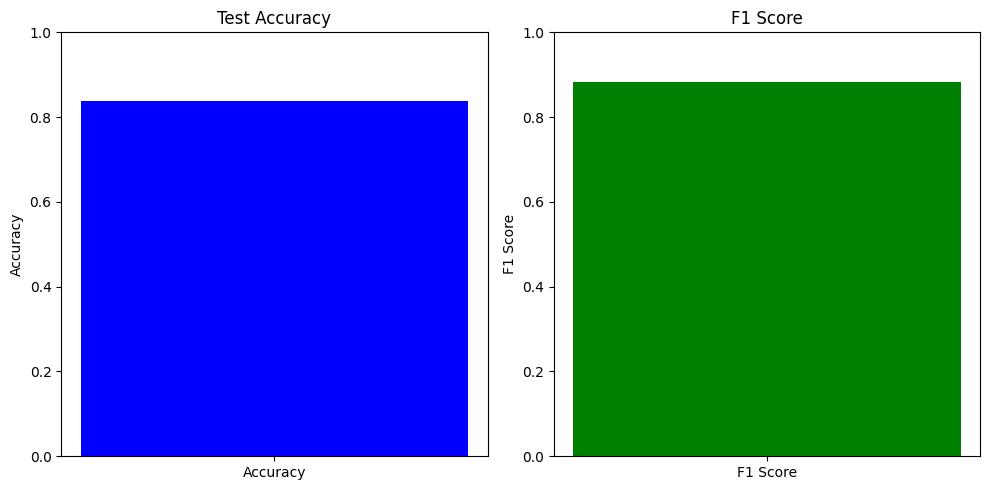

In [6]:
# Create the graph
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy bar chart
axes[0].bar(['Accuracy'], [test_acc], color='blue')
axes[0].set_ylim([0, 1])
axes[0].set_title('Test Accuracy')
axes[0].set_ylabel('Accuracy')

# F1 Score bar chart
axes[1].bar(['F1 Score'], [f1], color='green')
axes[1].set_ylim([0, 1])
axes[1].set_title('F1 Score')
axes[1].set_ylabel('F1 Score')

# Display the graphs
plt.tight_layout()
plt.show()

# visualize Training and Validation Accuracy and Loss

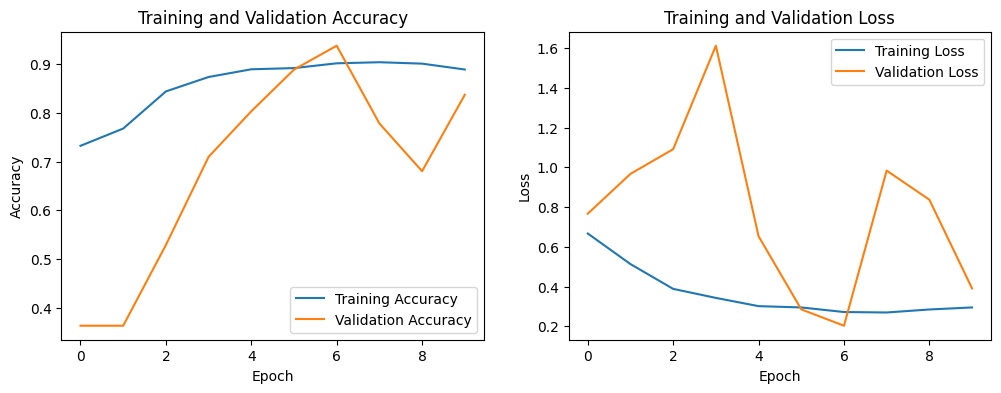

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


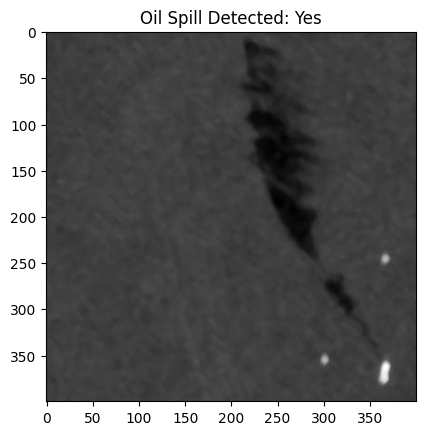

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


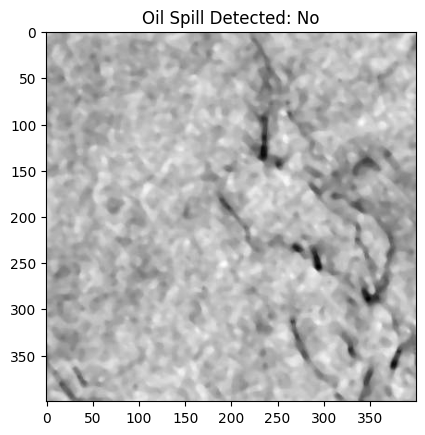

In [31]:
import cv2
def predict_new_image(model, image_path):
    new_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    new_image_resized = cv2.resize(new_image, (IMG_SIZE, IMG_SIZE))
    new_image_resized = new_image_resized.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    # Make a prediction
    prediction = model.predict(new_image_resized)

    # Reverse the interpretation
    is_oil_spill = prediction <= 0.5  # Original: prediction > 0.5
    plt.imshow(new_image, cmap='gray')
    plt.title(f"Oil Spill Detected: {'Yes' if is_oil_spill else 'No'}")
    plt.show()

# Example usage
predict_new_image(model, 'new_image (7).jpg')
predict_new_image(model, 'new_image (6).jpg')



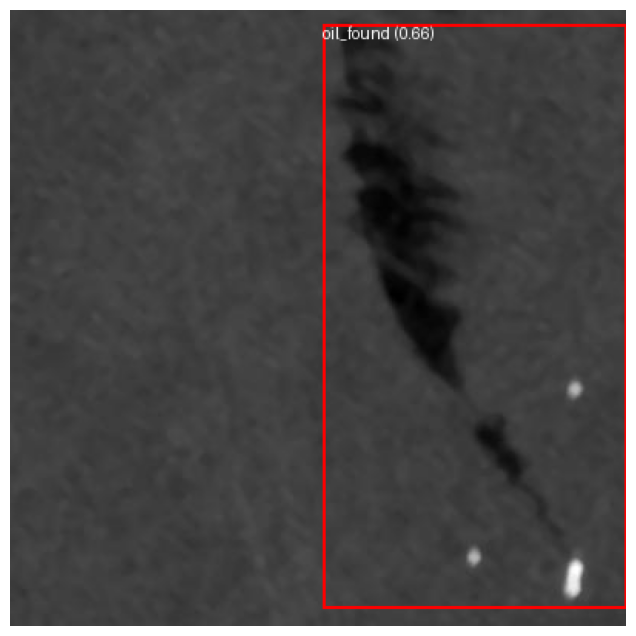

In [1]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="JxpBDHTQ8l44CDjW190L"
)

# infer on a local image
image_path = "1234.jpg"
result = CLIENT.infer(image_path, model_id="oil_detection-6r1iu/1")

# load the image
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# extract bounding boxes and labels from result
for prediction in result['predictions']:
    x, y, w, h = prediction['x'], prediction['y'], prediction['width'], prediction['height']
    label = prediction['class']
    confidence = prediction['confidence']

    # Calculate the box coordinates
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2

    # Draw the bounding box and label
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    draw.text((xmin, ymin), f"{label} ({confidence:.2f})", fill="white")

# display the image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()


In [2]:
# YOLO V9 FOR CLASSIFICATION INFERED FROM YOLO


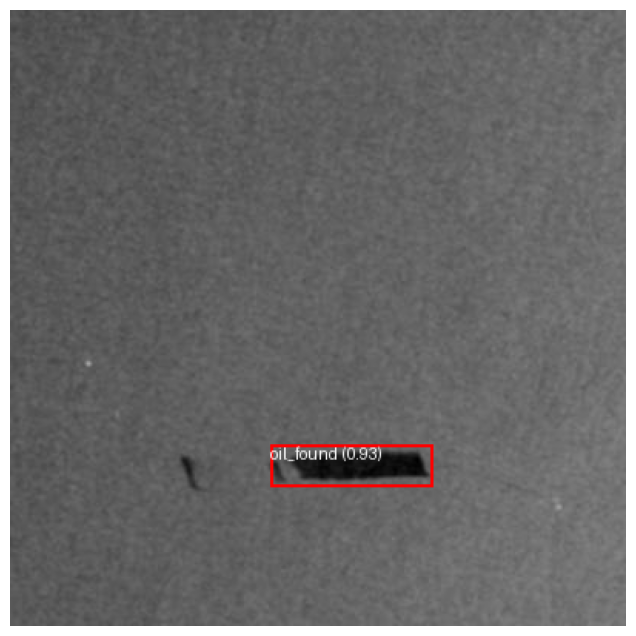

In [5]:
# import the inference-sdk
from inference_sdk import InferenceHTTPClient
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# initialize the client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="JxpBDHTQ8l44CDjW190L"
)

# infer on a local image
image_path = "SIRO_dataset\\oil\\oil_image (55).jpg"
result = CLIENT.infer(image_path, model_id="oil_detection-6r1iu/1")

# load the image
image = Image.open(image_path)
draw = ImageDraw.Draw(image)

# extract bounding boxes and labels from result
for prediction in result['predictions']:
    x, y, w, h = prediction['x'], prediction['y'], prediction['width'], prediction['height']
    label = prediction['class']
    confidence = prediction['confidence']

    # Calculate the box coordinates
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2

    # Draw the bounding box and label
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)
    draw.text((xmin, ymin), f"{label} ({confidence:.2f})", fill="white")

# display the image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()
